### Import Library

In [614]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from tensorflow import keras
from scipy.stats import norm, skew

import re
from tqdm import tqdm

In [615]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,8)},
        style='darkgrid',
       )

### GPU checking

In [616]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1370274043182829796
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11387741657422008483
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [617]:
"""
print('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
"""

"\nprint('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))\ntry:\n    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))\nexcept:\n    print('GPUs are not allocated. Current runtime is on CPU.')\n"

### Import data

In [618]:
data = pd.read_csv("data/data.csv")

In [619]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1,distance
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.10,NaN,0.0,36.896198,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,26.743154
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0,26.110083
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,27.539522
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,32.448371
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,4700.00,NaN,0.0,36.872700,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,7.887498


### Processing missing data & Drop unnecessary data

In [620]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

<AxesSubplot:>

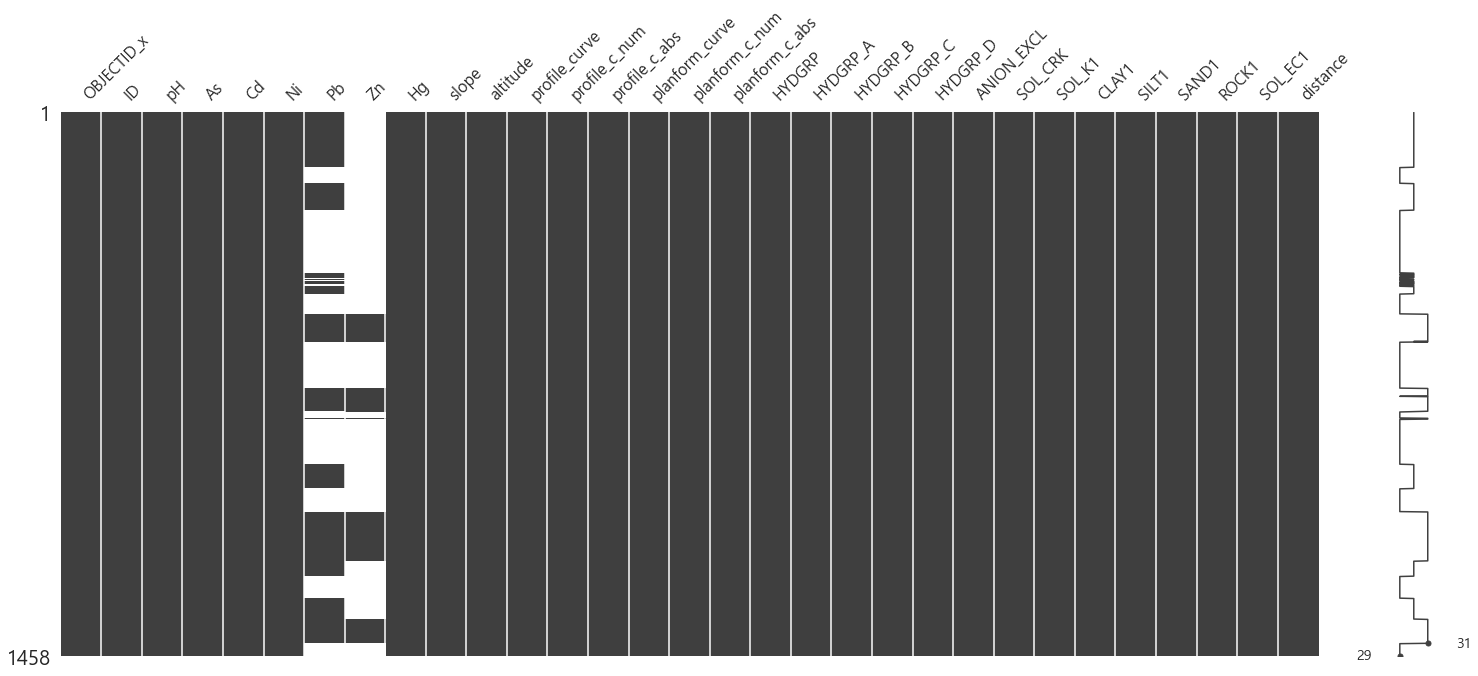

In [621]:
msno.matrix(data)

In [622]:
data = data.drop(['ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)

### train / test split & eliminate outlier

In [623]:
def eli_outlier(data, value):
        q1 = data[value].quantile(0.25)
        q3 = data[value].quantile(0.75)
        
        iqr = q3 - q1
        
        q1_condition = data[value] < q1-1.5*iqr
        q3_condition = data[value] > q3+1.5*iqr
        
        reset_q1_index = data[q1_condition].index
        reset_q3_index = data[q3_condition].index
        
        data.drop(reset_q1_index, inplace = True)
        data.drop(reset_q3_index, inplace = True)        

In [624]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [625]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
# train

As_train = train.drop(['OBJECTID_x','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['OBJECTID_x','As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['OBJECTID_x','As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['OBJECTID_x','As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['OBJECTID_x','As','Cd','Ni','Pb','Hg'], axis=1)

eli_outlier(As_train, 'As')
eli_outlier(Cd_train, 'Cd')
eli_outlier(Ni_train, 'Ni')

In [626]:
# test

As_test = test
Cd_test = test
Ni_test = test

eli_outlier(As_test, 'As')
eli_outlier(Cd_test, 'Cd')
eli_outlier(Ni_test, 'Ni')

As_test = As_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_test = Cd_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_test = Ni_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [627]:
As_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031 entries, 670 to 1162
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              1031 non-null   float64
 1   As              1031 non-null   float64
 2   slope           1031 non-null   float64
 3   altitude        1031 non-null   float64
 4   profile_c_num   1031 non-null   float64
 5   profile_c_abs   1031 non-null   int64  
 6   planform_c_num  1031 non-null   float64
 7   planform_c_abs  1031 non-null   int64  
 8   HYDGRP_A        1031 non-null   int64  
 9   HYDGRP_B        1031 non-null   int64  
 10  HYDGRP_C        1031 non-null   int64  
 11  HYDGRP_D        1031 non-null   int64  
 12  SOL_K1          1031 non-null   float64
 13  CLAY1           1031 non-null   float64
 14  SILT1           1031 non-null   float64
 15  SAND1           1031 non-null   float64
 16  ROCK1           1031 non-null   float64
 17  distance        1031 non-null  

In [628]:
As_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 960 to 353
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              225 non-null    float64
 1   slope           225 non-null    float64
 2   altitude        225 non-null    float64
 3   profile_c_num   225 non-null    float64
 4   profile_c_abs   225 non-null    int64  
 5   planform_c_num  225 non-null    float64
 6   planform_c_abs  225 non-null    int64  
 7   HYDGRP_A        225 non-null    int64  
 8   HYDGRP_B        225 non-null    int64  
 9   HYDGRP_C        225 non-null    int64  
 10  HYDGRP_D        225 non-null    int64  
 11  SOL_K1          225 non-null    float64
 12  CLAY1           225 non-null    float64
 13  SILT1           225 non-null    float64
 14  SAND1           225 non-null    float64
 15  ROCK1           225 non-null    float64
 16  distance        225 non-null    float64
dtypes: float64(11), int64(6)
memory u

### Check the value skewed

#### As

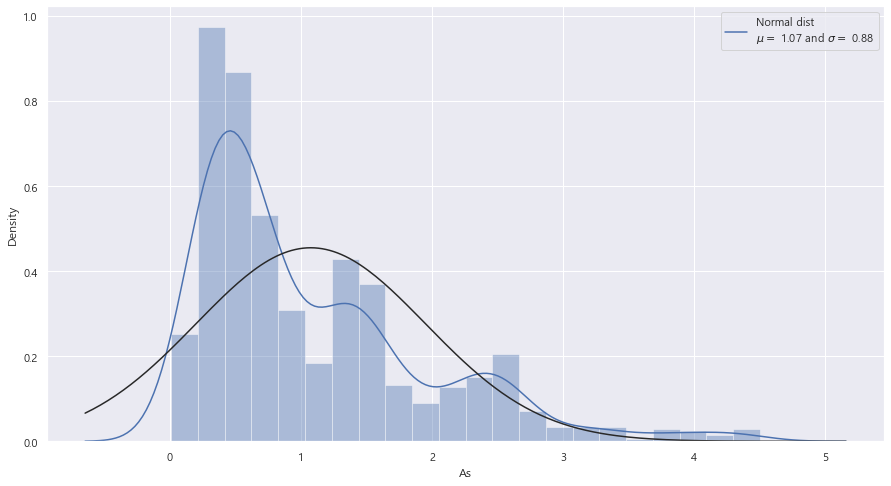

In [629]:
sns.distplot(As_train.As, fit = norm)
(mu, sigma) = norm.fit(As_train['As'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

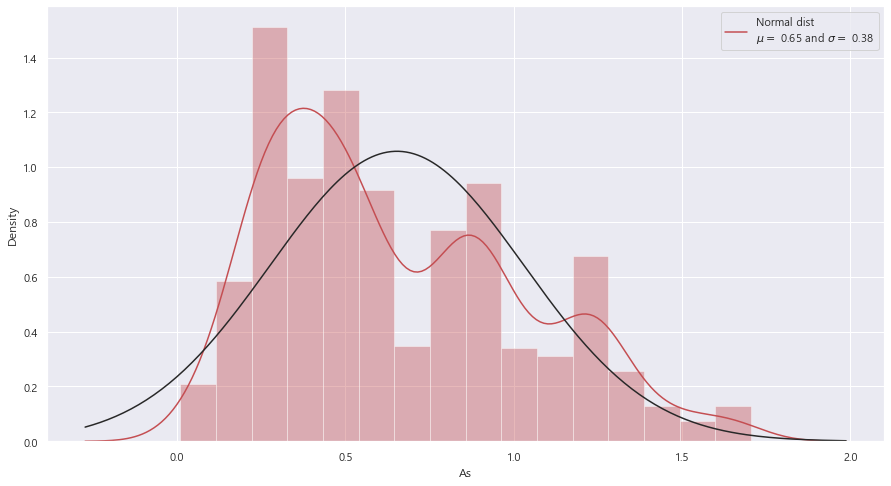

In [630]:
# 로그변환

sns.distplot(np.log1p(As_train.As), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(As_train['As']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Cd

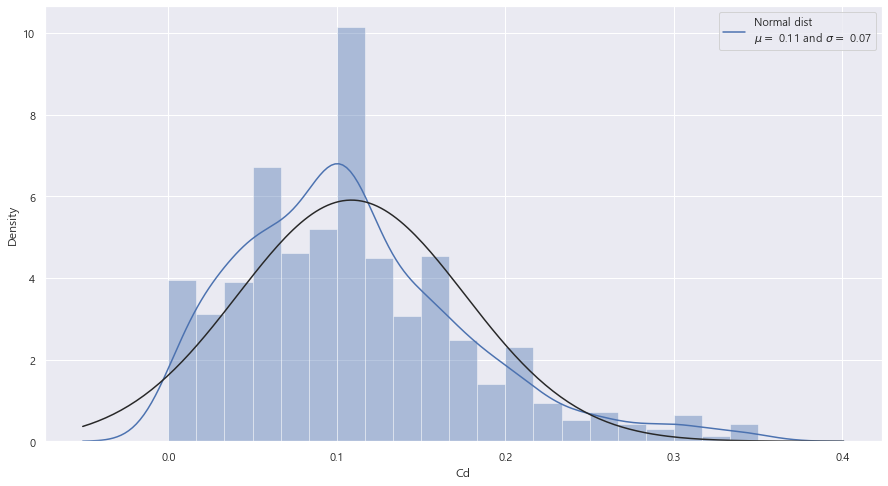

In [631]:
sns.distplot(Cd_train.Cd, fit = norm)
(mu, sigma) = norm.fit(Cd_train['Cd'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

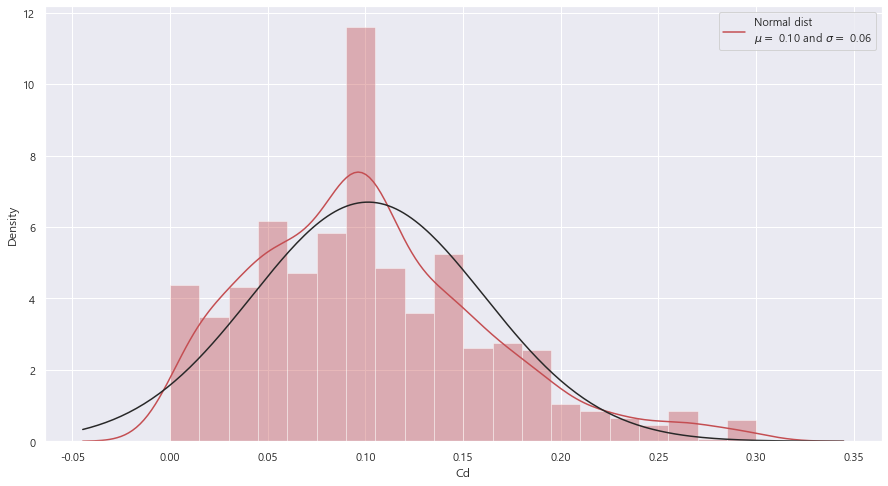

In [632]:
# 로그변환

sns.distplot(np.log1p(Cd_train.Cd), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Cd_train['Cd']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Ni

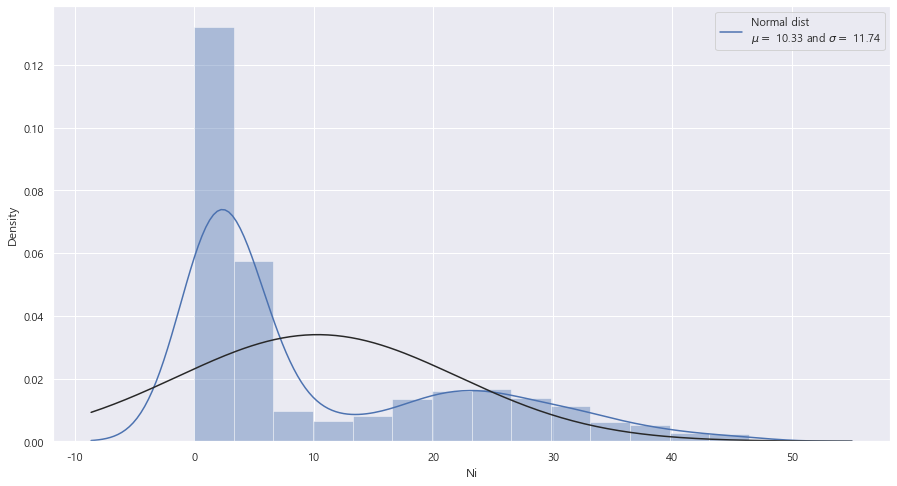

In [633]:
sns.distplot(Ni_train.Ni, fit = norm)
(mu, sigma) = norm.fit(Ni_train['Ni'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

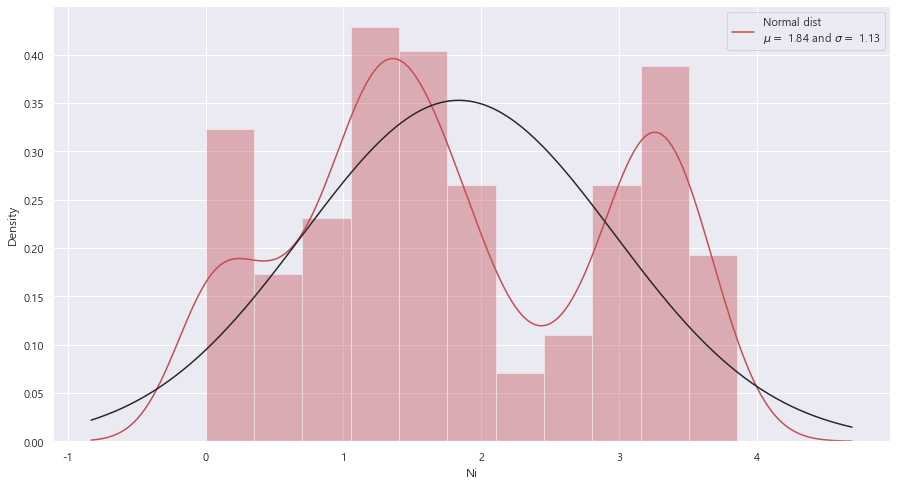

In [634]:
# 로그변환

sns.distplot(np.log1p(Ni_train.Ni), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Ni_train['Ni']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Log-Transformation

In [635]:
As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

"""
As_train.altitude = np.log1p(As_train.altitude)
Cd_train.altitude = np.log1p(Cd_train.altitude)
Ni_train.altitude = np.log1p(Ni_train.altitude)

As_train.slope = np.log1p(As_train.slope)
Cd_train.slope = np.log1p(Cd_train.slope)
Ni_train.slope = np.log1p(Ni_train.slope)
"""

'\nAs_train.altitude = np.log1p(As_train.altitude)\nCd_train.altitude = np.log1p(Cd_train.altitude)\nNi_train.altitude = np.log1p(Ni_train.altitude)\n\nAs_train.slope = np.log1p(As_train.slope)\nCd_train.slope = np.log1p(Cd_train.slope)\nNi_train.slope = np.log1p(Ni_train.slope)\n'

In [636]:
As_test_index = As_test.index
Cd_test_index = Cd_test.index
Ni_test_index = Ni_test.index

#### Scaling

In [637]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [638]:
scaler = StandardScaler()

scaler.fit(As_X)
As_X = pd.DataFrame(scaler.transform(As_X), columns=As_X.columns)
As_test = pd.DataFrame(scaler.transform(As_test), columns=As_test.columns)

scaler.fit(Cd_X)
Cd_X = pd.DataFrame(scaler.transform(Cd_X), columns=Cd_X.columns)
Cd_test = pd.DataFrame(scaler.transform(Cd_test), columns=Cd_test.columns)

scaler.fit(Ni_X)
Ni_X = pd.DataFrame(scaler.transform(Ni_X), columns=Ni_X.columns)
Ni_test = pd.DataFrame(scaler.transform(Ni_test), columns=Ni_test.columns)


### DNN model

In [639]:
def simpleDNN(train):
    weight_decay = 0.001
    learning_rate = 0.01

    # structure :
    
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(train.shape[1],), 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2048, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu', 
                           kernel_regularizer=keras.regularizers.l2(weight_decay)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    
    return model, learning_rate

#### AS

In [640]:
model, eta = simpleDNN(As_X)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), 
              loss='mse', metrics=['mse'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=30, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10, verbose=0, mode='auto', 
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

In [641]:
As_history = model.fit(As_X, As_y, validation_split=0.1, 
                        epochs=1000, batch_size=256, callbacks=[early_stopping, lr_scheduler], 
                        verbose=0)

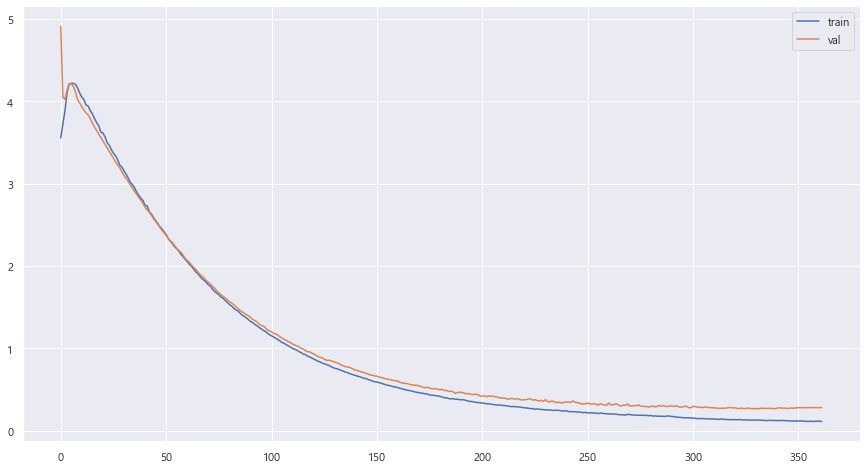

0.27338361740112305


In [642]:
plt.plot(As_history.history['loss'][3:], label='train')
plt.plot(As_history.history['val_loss'][3:], label='val')
plt.legend()
plt.show()
print(As_history.history['val_loss'][-30])

In [643]:
# predict
As_pred = model.predict(As_test)

# reverse log scailing
As_pred = np.expm1(As_pred)

#### Cd

In [644]:
model, eta = simpleDNN(Cd_X)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), 
              loss='mse', metrics=['mse'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=30, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10, verbose=0, mode='auto', 
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

In [645]:
Cd_history = model.fit(Cd_X, Cd_y, validation_split=0.1, 
                        epochs=1000, batch_size=256, callbacks=[early_stopping, lr_scheduler], 
                        verbose=0)

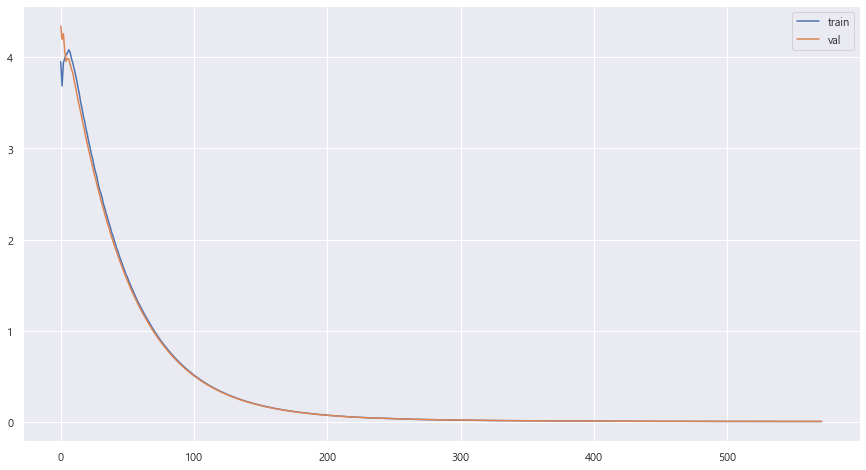

0.008866047486662865


In [646]:
plt.plot(Cd_history.history['loss'][3:], label='train')
plt.plot(Cd_history.history['val_loss'][3:], label='val')
plt.legend()
plt.show()
print(Cd_history.history['val_loss'][-30])

In [647]:
# predict
Cd_pred = model.predict(Cd_test)

# reverse log scailing
Cd_pred = np.expm1(Cd_pred)

#### Ni

In [648]:
model, eta = simpleDNN(Ni_X)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), 
              loss='mse', metrics=['mse'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=30, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=10, verbose=0, mode='auto', 
                                                 min_delta=0.0001, cooldown=0, min_lr=0)

In [649]:
Ni_history = model.fit(Ni_X, Ni_y, validation_split=0.1, 
                        epochs=1000, batch_size=256, callbacks=[early_stopping, lr_scheduler], 
                        verbose=0)

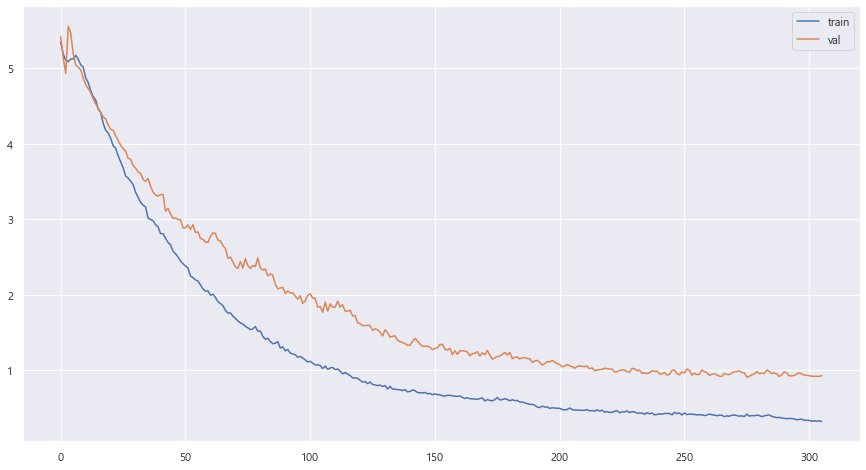

0.9181348085403442


In [650]:
plt.plot(Ni_history.history['loss'][3:], label='train')
plt.plot(Ni_history.history['val_loss'][3:], label='val')
plt.legend()
plt.show()
print(Ni_history.history['val_loss'][-30])

In [651]:
# predict
Ni_pred = model.predict(Cd_test)

# reverse log scailing
Ni_pred = np.expm1(Cd_pred)

### Evaluate Model

In [652]:
As_test = pd.DataFrame()
Cd_test = pd.DataFrame()
Ni_test = pd.DataFrame()

As_test['index'] = As_test_index
Cd_test['index'] = Cd_test_index
Ni_test['index'] = Ni_test_index

for index in As_test['index']:
    As_test.loc[As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    
for index in Cd_test['index']:
    Cd_test.loc[Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']

for index in Ni_test['index']:
    Ni_test.loc[As_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']

In [653]:
def SST(data, pred):
    sst = 0
    
    for i in range(0, len(pred)):
        sst += ((data[i] - np.mean(data))**2)
        
    return sst

def SSE(data, pred):
    sse = 0
    
    for i in range(0, len(pred)):
        sse += ((pred[i] - np.mean(data))**2)
        
    return sse

def SSR(data, pred):
    ssr = 0
    
    for i in range(0, len(data)):
        ssr += ((data[i] - pred[i])**2)
    
    return ssr

#### r2 scoring

In [654]:
def cal_train_r2(pred, value):
    test = pd.DataFrame()
    test['real_value'] = np.array(value)
    test['value'] = pred


    sse = SSE(test['real_value'], test['value'])
    #ssr = SSR(test['real_value'], test['value'])
    #sst = sse + ssr
    sst = SST(test['real_value'], test['value'])
    
    test_r2 = sse/sst
    #test_r2 = r2_score(test['real_value'], test['value'])
    print(f'r2 score : {test_r2}')

In [655]:
cal_train_r2(As_pred, As_test['As_real_value'])
cal_train_r2(Cd_pred, Cd_test['Cd_real_value'])
cal_train_r2(Ni_pred, Ni_test['Ni_real_value'])

r2 score : 0.22279367911740924
r2 score : 0.2607960955921689
r2 score : 0.6648889692184548


#### rmse scoring

In [656]:
def cal_rmse(pred, value):
    test = pd.DataFrame()
    test['real_value'] = np.array(value)
    test['value'] = pred

    rmse = np.sqrt(mean_squared_error(test['real_value'], test['value']))
    print(f'rmse : {rmse}')

In [657]:
cal_rmse(As_pred, As_test['As_real_value'])
cal_rmse(Cd_pred, Cd_test['Cd_real_value'])
cal_rmse(Ni_pred, Ni_test['Ni_real_value'])

rmse : 0.7742219834691154
rmse : 0.06161640320114249
rmse : 14.684900466659348


### Visualization

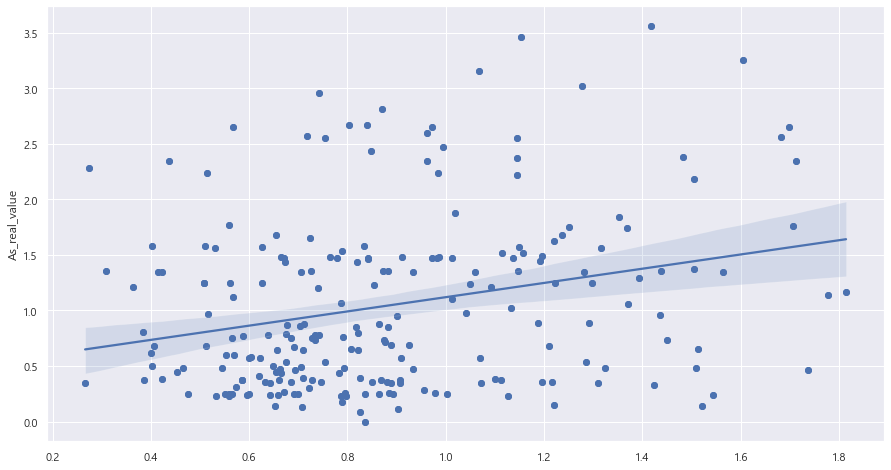

In [658]:
plt.scatter(As_pred, As_test['As_real_value'])
sns.regplot(As_pred, As_test['As_real_value'])
plt.show()